In [1]:
import sys

assert sys.version_info >= (3, 7)

In [2]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

# Linear Regression

## Normal Equation

In [1]:
import numpy as np
np.random.seed(42)

m = 100
X = 2 * np.random.rand(m, 1)
y = 4 + 3 * X + np.random.rand(m, 1)

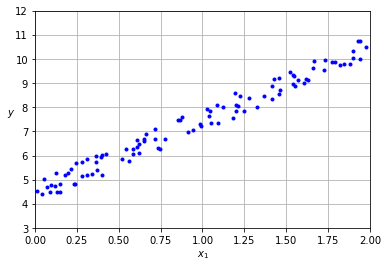

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 3, 12])
plt.grid()

plt.show()

In [5]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [6]:
X_b.shape

(100, 2)

In [7]:
theta_best

array([[4.51359766],
       [2.98323418]])

In [8]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)

y_predict = X_new_b @ theta_best
y_predict

array([[ 4.51359766],
       [10.48006601]])

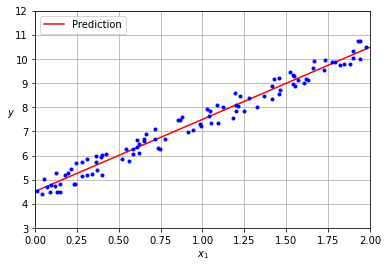

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X_new, y_predict, 'r-', label='Prediction')
plt.plot(X, y, 'b.')

plt.xlabel('$x_1$')
plt.ylabel('$y$',rotation=0)
plt.axis([0, 2, 3, 12])
plt.grid()
plt.legend(loc='upper left')

plt.show()

## compare Normal equation result with linear regression module in sklearn

In [10]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [11]:
lin_reg.intercept_

array([4.51359766])

In [12]:
lin_reg.coef_

array([[2.98323418]])

In [13]:
lin_reg.predict(X_new)

array([[ 4.51359766],
       [10.48006601]])

## Calculating $\theta$ with np.linalg

In [14]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.51359766],
       [2.98323418]])

In [15]:
np.linalg.pinv(X_b) @ y

array([[4.51359766],
       [2.98323418]])

# Gradient Descent

## Batch Gradient Descent

In [16]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
  gradients = 2/m * X_b.T @ (X_b@theta - y)
  theta = theta - eta * gradients

In [17]:
theta

array([[4.51359766],
       [2.98323418]])

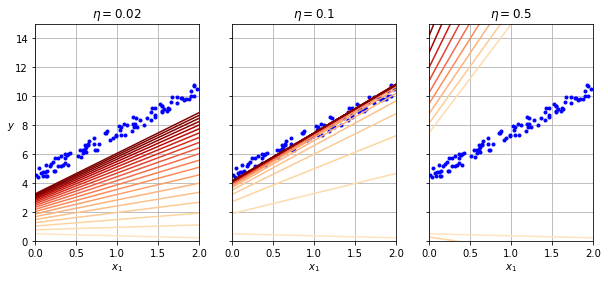

In [18]:
import matplotlib as mpl

def plot_gradient_descent(theta, eta):
  m = len(X_b)
  plt.plot(X, y, "b.")
  n_epochs = 1000
  n_shown = 20
  theta_path = []
  for epoch in range(n_epochs):
    if epoch < n_shown:
      y_predict = X_new_b @ theta
      color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
      plt.plot(X_new, y_predict, linestyle="solid", color=color)
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients
    theta_path.append(theta)
  plt.xlabel("$x_1$")
  plt.axis([0, 2, 0, 15])
  plt.grid()
  plt.title(fr"$\eta = {eta}$")
  return theta_path

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])
plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
# save_fig("gradient_descent_plot")
plt.show()

## Stochastic Gradient Descent

In [19]:
theta_path_sgd = []

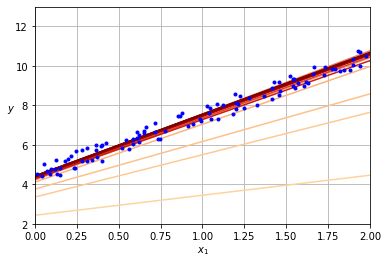

In [20]:
n_epochs = 50
t0, t1 = 5, 50

def learning_schedule(t):
  return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)

n_shown = 20
plt.figure(figsize=(6, 4))

for epoch in range(n_epochs):
  for iteration in range(m):

    if epoch == 0 and iteration < n_shown:
      y_predict = X_new_b @ theta
      color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
      plt.plot(X_new, y_predict, color=color)

    random_index = np.random.randint(m)
    xi = X_b[random_index: random_index+1]
    yi = y[random_index: random_index+1]
    gradients = 2 * xi.T @ (xi @ theta - yi)
    eta = learning_schedule(epoch * m + iteration)
    theta = theta - eta * gradients
    theta_path_sgd.append(theta)

plt.plot(X, y, 'b.')
plt.xlabel('$x_1$')
plt.ylabel('$y$', rotation=0)
plt.axis([0, 2, 2, 13])
plt.grid()

plt.show()

In [21]:
theta

array([[4.51548062],
       [2.9775157 ]])

### SGD with skleaern linear regression

In [22]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01, n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [23]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.50316965]), array([2.99156535]))

## Mini-Batch Gradient Descent

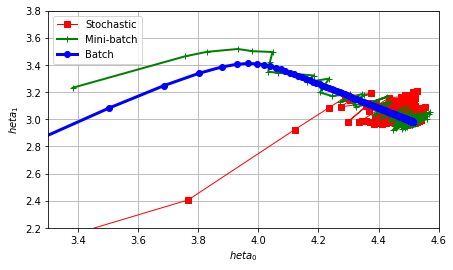

In [24]:
from math import ceil

n_epochs = 50
minibatch_size = 20 
m = len(X_b)
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000

def learning_schedule(t):
  return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
  shuffled_indices = np.random.permutation(m)
  X_b_shuffled = X_b[shuffled_indices]
  y_shuffled = y[shuffled_indices]
  for iteration in range(0, n_batches_per_epoch):
    idx = iteration * minibatch_size
    xi = X_b_shuffled[idx: idx + minibatch_size]
    yi = y_shuffled[idx: idx + minibatch_size]
    gradients = 2 /minibatch_size * xi.T @ (xi @ theta - yi)
    eta = learning_schedule(iteration)
    theta = theta - eta * gradients
    theta_path_mgd.append(theta)

theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], 'r-s', linewidth=1, label='Stochastic')
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], 'g-+', linewidth=2, label='Mini-batch')
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], 'b-o', linewidth=3, label='Batch')

plt.legend(loc='upper left')
plt.xlabel('$\theta_0$')
plt.ylabel('$\theta_1$')
plt.axis([3.3, 4.6, 2.2, 3.8])
plt.grid()

plt.show()

## TIPS on Gradients and NE, SVD

If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.

---

If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.

# Polynomial Regression

In [25]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.rand(m, 1)

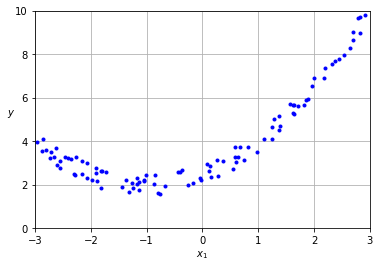

In [26]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, 'b.')
plt.xlabel('$x_1$')
plt.ylabel('$y$', rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()

plt.show()

In [27]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [28]:
X[0]

array([-0.75275929])

In [29]:
X_poly[0]

array([-0.75275929,  0.56664654])

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [31]:
lin_reg.intercept_, lin_reg.coef_

(array([2.49786712]), array([[0.9943591 , 0.49967213]]))

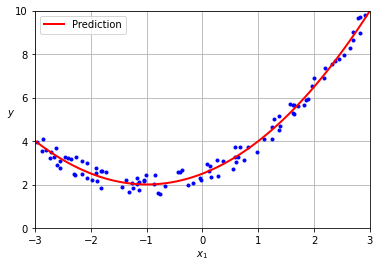

In [32]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, 'b.')
plt.plot(X_new, y_new, 'r-', linewidth=2, label='Prediction')
plt.xlabel('$x_1$')
plt.ylabel('$y$', rotation=0)
plt.axis([-3, 3, 0, 10])
plt.legend(loc="upper left")
plt.grid()

plt.show()

# Learning Curves

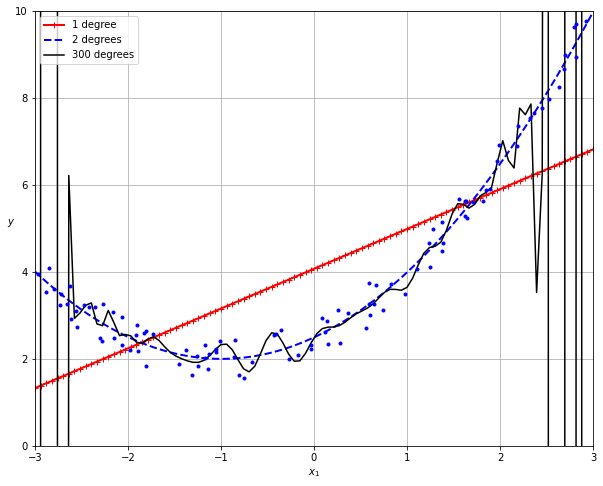

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(10, 8))

for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("k-", 1.5, 300)):
  polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
  std_scaler = StandardScaler()
  lin_reg = LinearRegression()
  polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
  polynomial_regression.fit(X, y)
  y_newbig = polynomial_regression.predict(X_new)
  label = f"{degree} degree{'s' if degree > 1 else ''}"
  plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()

plt.show()

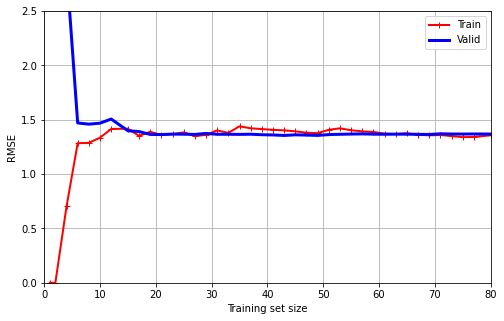

In [34]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(LinearRegression(), X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='neg_root_mean_squared_error')
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label='Train')
plt.plot(train_sizes, valid_errors, 'b-', linewidth=3, label='Valid')

plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.grid()
plt.legend(loc='upper right')
plt.axis([0, 80, 0, 2.5])

plt.show()

In [35]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression()
)

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y, train_sizes=np.linspace(0.01, 1.0, 40), cv=5, scoring='neg_root_mean_squared_error'
)


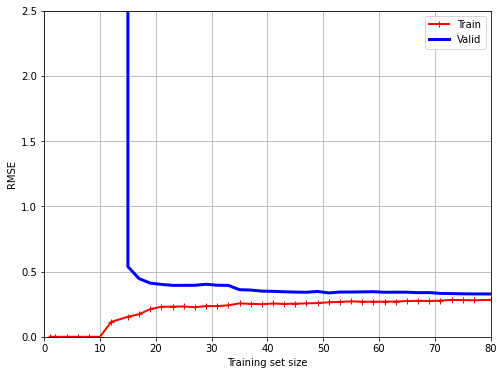

In [36]:
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_errors, 'r-+', linewidth=2, label='Train')
plt.plot(train_sizes, valid_errors, 'b-', linewidth=3, label='Valid')
plt.legend(loc='upper right')
plt.xlabel('Training set size')
plt.ylabel('RMSE')
plt.grid()
plt.axis([0, 80, 0, 2.5])

plt.show()

# Regularized Linear Model

## Ridge Regression

In [37]:
np.random.seed(42)

m = 30
X = 3 * np.random.rand(m, 1)
y = 2 + 0.5*X + np.random.rand(m, 1)/1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

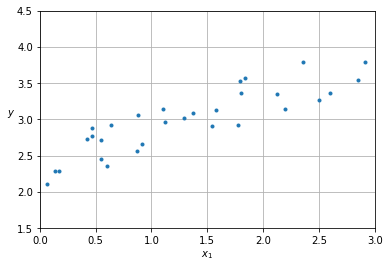

In [38]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)
plt.axis([0, 3, 1.5, 4.5])
plt.grid()
plt.show()

In [39]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1, solver='cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[3.07286975]])

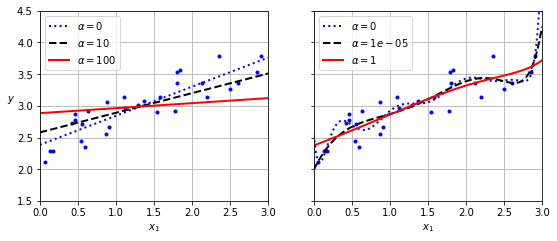

In [40]:
def plot_model(model_class, polynomial, alphas, **model_kwargs):
  plt.plot(X, y, "b.", linewidth=3)
  for alpha, style in zip(alphas, ("b:", "k--", "r-")):
    if alpha > 0:
        model = model_class(alpha, **model_kwargs)
    else:
        model = LinearRegression()
    if polynomial:
        model = make_pipeline(
            PolynomialFeatures(degree=10, include_bias=False),
            StandardScaler(),
            model)
    model.fit(X, y)
    y_new_regul = model.predict(X_new)
    plt.plot(X_new, y_new_regul, style, linewidth=2,
              label=fr"$\alpha = {alpha}$")
  plt.legend(loc="upper left")
  plt.xlabel("$x_1$")
  plt.axis([0, 3, 1.5, 4.5])
  plt.grid()

plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 10**-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()

### Ridge with SGD

In [41]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1 / m, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets
sgd_reg.predict([[1.5]])

array([3.07260574])

In [42]:
ridge_reg = Ridge(alpha=0.1, solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[3.0724851]])

In [43]:
alpha = 0.1
A = np.array([[0., 0.], [0., 1.]])
X_b = np.c_[np.ones(m), X]
np.linalg.inv(X_b.T @ X_b + alpha * A) @ X_b.T @ y


array([[2.38855434],
       [0.45621027]])

In [44]:
ridge_reg.intercept_, ridge_reg.coef_ 

(array([2.39130187]), array([[0.45412216]]))

## Lasso Regression

In [45]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([3.04672514])

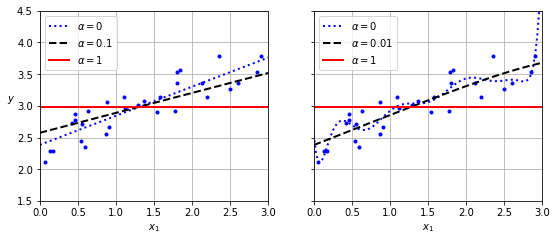

In [46]:
plt.figure(figsize=(9, 3.5))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("$y$  ", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 1e-2, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])

plt.show()

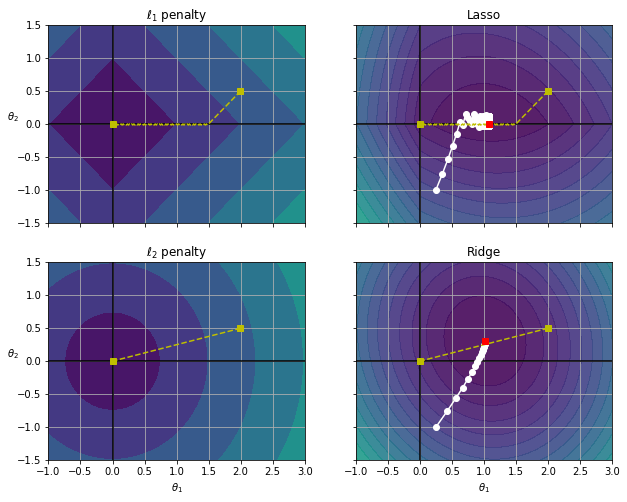

In [47]:
t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])

def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (core * 2 / len(X) * X.T @ (X @ theta - y)
                     + l1 * np.sign(theta) + l2 * theta)
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2 ** 2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(theta=np.array([[2.0], [0.5]]), X=Xr, y=yr,
                      l1=np.sign(l1) / 3, l2=np.sign(l2), core=0)
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(fr"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

plt.show()

In [48]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([3.04672514])

## Elastic Net Regression

In [49]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([3.05521566])

## Early Stopping

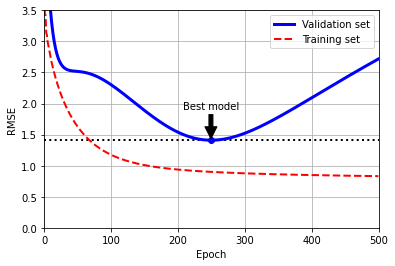

In [52]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2  + X + 2 + np.random.randn(m ,1)
X_train, y_train = X[: m //2], y[: m//2, 0]
X_valid, y_valid = X[m//2:], y[m//2:, 0]

preprocessing = make_pipeline(PolynomialFeatures(degree=90, include_bias=False), StandardScaler())
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)

sgd_reg = SGDRegressor(penalty=None, eta0=0.002, random_state=42)
n_epochs = 500

best_valid_rmse = float('inf')
train_errors, val_errors = [], []

for epoch in range(n_epochs):
  sgd_reg.partial_fit(X_train_prep, y_train)
  y_valid_predict = sgd_reg.predict(X_valid_prep)

  val_error = mean_squared_error(y_valid, y_valid_predict, squared=False)
  if val_error < best_valid_rmse:
    best_valid_rmse = val_error
    best_model = deepcopy(sgd_reg)

  y_train_predict = sgd_reg.predict(X_train_prep)
  train_error = mean_squared_error(y_train, y_train_predict, squared=False)
  val_errors.append(val_error)
  train_errors.append(train_error)

best_epoch = np.argmin(val_errors)
plt.figure(figsize=(6, 4))
plt.annotate('Best model', xy=(best_epoch, best_valid_rmse), xytext=(best_epoch, best_valid_rmse+0.5), ha='center', 
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], 'k:', linewidth=2)
plt.plot(val_errors, 'b-', linewidth=3, label='Validation set')
plt.plot(best_epoch, best_valid_rmse, 'bo')
plt.plot(train_errors, 'r--', linewidth=2, label='Training set')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.axis([0, n_epochs, 0, 3.5])
plt.grid()

plt.show()

# Logistic Regression

## Estimating Probabilities

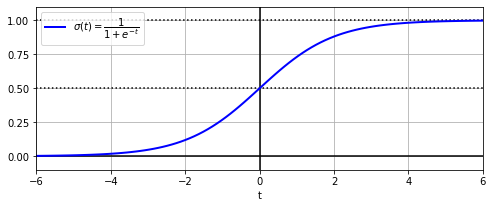

In [54]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [-1.1, 1.1], "k-")
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.xlabel("t")
plt.legend(loc="upper left")
plt.axis([-lim, lim, -0.1, 1.1])
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1])
plt.grid()

plt.show()

## Decision Boundary

In [3]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [4]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [57]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [58]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int64

In [60]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[['petal width (cm)']].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

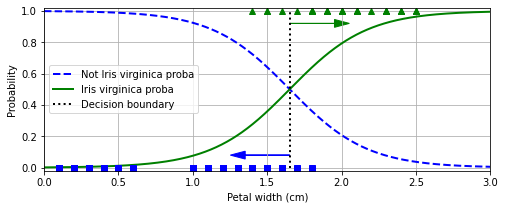

In [63]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

plt.figure(figsize=(8, 3))
plt.plot(X_new, y_proba[:, 0], 'b--', linewidth=2, label="Not Iris virginica proba")
plt.plot(X_new, y_proba[:, 1], 'g-', linewidth=2, label='Iris virginica proba')
plt.plot([decision_boundary, decision_boundary], [0, 1], 'k:', linewidth=2, label='Decision boundary')

plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0, head_width=0.05, head_length=0.1, fc='b', ec='b')
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0, head_width=0.05, head_length=0.1, fc='g', ec='g')
plt.plot(X_train[y_train==0], y_train[y_train==0], 'bs') # Plotting not iris virginica samples
plt.plot(X_train[y_train==1], y_train[y_train==1], 'g^') # Plotting iris virginica samples
plt.xlabel("Petal width (cm)")
plt.ylabel('Probability')
plt.legend(loc='center left')
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

In [64]:
decision_boundary

1.6516516516516517

In [65]:
log_reg.predict([[1.7], [1.5]])

array([ True, False])

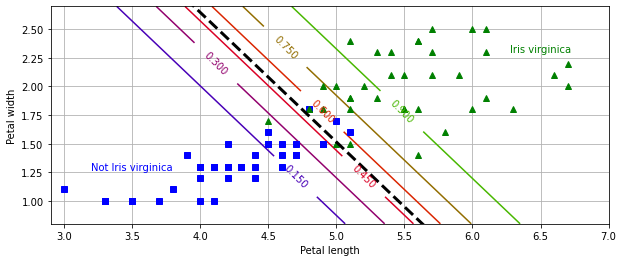

In [66]:

X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

# for the contour plot
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # one instance per point on the figure
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

# for the decision boundary
left_right = np.array([2.9, 7])
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k--", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()

plt.show()

## Softmax Regression

In [67]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

In [68]:
softmax_reg.predict([[5, 2]])

array([2])

In [69]:
softmax_reg.predict_proba([[5, 2]]).round(2)

array([[0.  , 0.04, 0.96]])

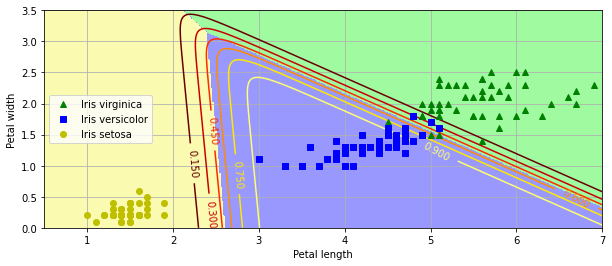

In [70]:
from matplotlib.colors import ListedColormap

custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()

plt.show()

# EXercise Solution that can be used as Summary

If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.

---

If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.

---

Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.

---

Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.

---

If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.

---

- Ridge vs plain linear regression: A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
- Lasso vs Ridge: Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
- Elastic vs Lasso: Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an l1_ratio close to 1.


## Bacth gradient descent with early stopping (softmax reg) ⛹

In [5]:
X = iris.data[['petal length (cm)', 'petal width (cm)']].values
y = iris.target.values

In [6]:
# Adding bias to X without using add_dummy-feature()
X_with_bias = np.c_[np.ones(len(X)), X]

In [7]:
# Splitting data without using train_test_split()
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size: -test_size]]
y_valid = y[rnd_indices[train_size: -test_size]]
X_test  = X_with_bias[rnd_indices[-test_size:]]
y_test  = y[rnd_indices[-test_size:]]

In [17]:
X_train.shape, y_train.shape

((90, 3), (90,))

In [8]:
def to_one_hot(y):
  return np.diag(np.ones(y.max() + 1))[y]

In [9]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

In [10]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [11]:
Y_train_one_hot = to_one_hot(y_train)
Y_valid_one_hot = to_one_hot(y_valid)
Y_test_one_hot  = to_one_hot(y_test)

In [12]:
# Scaling input
mean = X_train[:, 1:].mean(axis=0)
std  = X_train[:, 1:].std(axis=0)

X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:]  = (X_test[:, 1:] - mean) / std

In [13]:
def softmax(logits):
  exps = np.exp(logits)
  exps_sum = exps.sum(axis=1, keepdims=True)
  return exps / exps_sum

In [14]:
n_inputs = X_train.shape[1]
n_outputs = len(np.unique(y_train))

In [15]:
n_inputs, n_outputs

(3, 3)

In [16]:
eta = 0.5
n_epochs=5001
m = len(X_train)
epsilon = 1e-5

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  if epoch % 1000 == 0:
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    print(epoch, xentropy_losses.sum(axis=1).mean())

  error = Y_proba - Y_train_one_hot
  gradients = 1 / m * X_train.T @ error
  Theta = Theta - eta * gradients

0 3.7085808486476917
1000 0.14519367480830644
2000 0.1301309575504088
3000 0.12009639326384539
4000 0.11372961364786884
5000 0.11002459532472425


In [18]:
Theta

array([[ 0.41931626,  6.11112089, -5.52429876],
       [-6.53054533, -0.74608616,  8.33137102],
       [-5.28115784,  0.25152675,  6.90680425]])

In [19]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In [20]:
# Regularization
eta = 0.5
n_epochs=5001
m = len(X_train)
epsilon = 1e-5
alpha = 0.01 # <---- Regulizer l2

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  if epoch % 1000 == 0:
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + alpha*l2_loss
    print(epoch, total_loss.round(4))

  error = Y_proba - Y_train_one_hot
  gradients = 1 / m * X_train.T @ error
  gradients += np.r_[np.zeros([1, n_outputs]), alpha*Theta[1:]]
  Theta = Theta - eta * gradients

0 3.7372
1000 0.3259
2000 0.3259
3000 0.3259
4000 0.3259
5000 0.3259


In [21]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

In [22]:
# Early stopping

eta = 0.5
n_epochs=5001
m = len(X_train)
epsilon = 1e-5
C = 100 # <-- regulization hyperparameter
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
  logits = X_train @ Theta
  Y_proba = softmax(logits)
  Y_proba_valid = softmax(X_valid @ Theta)
  xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
  l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
  total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
  if epoch % 1000 == 0:
      print(epoch, total_loss.round(4))
  if total_loss < best_loss:
      best_loss = total_loss
  else:
      print(epoch - 1, best_loss.round(4))
      print(epoch, total_loss.round(4), "early stopping!")
      break
  error = Y_proba - Y_train_one_hot
  gradients = 1 / m * X_train.T @ error
  gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
  Theta = Theta - eta * gradients

0 3.7372
281 0.3256
282 0.3256 early stopping!


In [23]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

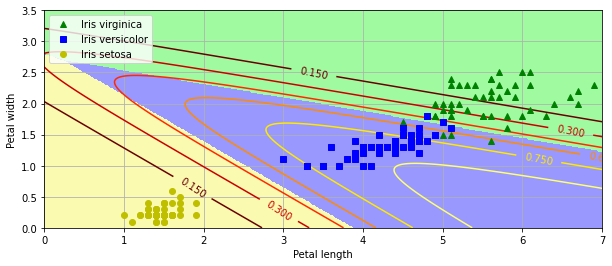

In [25]:
import matplotlib as mpl
custom_cmap = mpl.colors.ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

In [26]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667